In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from focal_loss import BinaryFocalLoss
from sklearn.metrics import recall_score, precision_score
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_sample_weight


## Load Data

In [70]:
dfolder = '../data/'

In [71]:
df_final = pd.read_csv(dfolder + 'preprocessed_df.csv')

## Preprocessing

In [72]:
df_final['country'] = df_final['Country Name']

In [73]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]


## Normalizing

Here i'm taking the top 10 countries for model intereprestability later

In [74]:
armedconfdf = df_final.drop(columns=['civilwar','Country Name', 'MonthYear', 'date', 'state_deaths','nonstate_deaths','onesided_deaths','civilian_deaths'])

In [75]:
armedconfdf.columns

Index(['isocode', 'month', 'year', 'deaths', 'month_year', 'wb_pop',
       'total_events', 'total_events_gov', 'total_events_opp',
       'share_events_count_events_1',
       ...
       'past6', 'past12', 'past60', 'past120', 'armedconf_since',
       'num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median', 'country'],
      dtype='object', length=103)

In [76]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['armedconf'].sum()).sort_values(by='armedconf',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [77]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']))

In [78]:
scaled_df=pd.DataFrame(data=scaled,columns=df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']).columns)


In [79]:
scaled_df

,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,...,deaths_state_pc,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,0.002054,0.002117,0.0,0.000000,0.001888,0.013818,0.001234,0.001357,0.001280,0.114855,...,0.004603,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220
1,0.001370,0.000000,0.0,0.012312,0.002614,0.011588,0.001280,0.001977,0.002246,0.131365,...,0.003658,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612
2,0.000000,0.000000,0.0,0.000000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,...,0.000000,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020
3,0.000000,0.000000,0.0,0.000000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004
4,0.000000,0.000000,0.0,0.000000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,...,0.000000,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54742,0.000000,0.000000,0.0,0.000000,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000
54743,0.000000,0.000000,0.0,0.000000,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,...,0.000000,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971
54744,0.000000,0.000000,0.0,0.000000,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,...,0.000000,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530
54745,0.000000,0.000000,0.0,0.000000,0.000000,0.013768,0.000620,0.000917,0.000042,0.146992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.624697,0.042918,0.000046,0.000034,0.000033


In [80]:
conf=df_final.copy()
conf[scaled_df.columns]=np.array(scaled_df)
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','year','month'])
conf

,,,MonthYear,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,year,month,,,,,,,,,,,,,,,,,,,,,
AFG,2000,1,1970-01-01 00:00:00.000200001,0.002054,0.002117,0.0,0.000000,0.001888,2000-01-01,Afghanistan,0.013818,2000-01-01,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,2000,1,1970-01-01 00:00:00.000200001,0.001370,0.000000,0.0,0.012312,0.002614,2000-01-01,Angola,0.011588,2000-01-01,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,2000,1,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,Albania,0.002168,2000-01-01,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,2000,1,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,United Arab Emirates,0.002299,2000-01-01,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,2000,1,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,Argentina,0.026228,2000-01-01,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,2023,5,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,Kosovo,0.001245,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,2023,5,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,"Yemen, Rep.",0.023333,2023-05-01,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,2023,5,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,South Africa,0.042033,2023-05-01,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


In [81]:
top_10_country_names

0                  Afghanistan
1                      Somalia
2                         Iraq
3                        Sudan
4             Congo, Dem. Rep.
5     Central African Republic
6                      Nigeria
7                       Israel
8                  Yemen, Rep.
9         Syrian Arab Republic
10                      Mexico
Name: country, dtype: object

In [82]:
conf.drop(['civilwar', 'Country Name', 'MonthYear', 'month_year', 'date', 'state_deaths','nonstate_deaths','onesided_deaths','civilian_deaths'], axis=1, inplace=True)


In [83]:
conf

,,,deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,year,month,,,,,,,,,,,,,,,,,,,,,
AFG,2000,1,0.002054,0.013818,0.001234,0.001357,0.001280,0.114855,0.045559,0.072741,0.346861,0.089969,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,2000,1,0.001370,0.011588,0.001280,0.001977,0.002246,0.131365,0.042804,0.085240,0.254982,0.052768,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,2000,1,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,0.046041,0.081400,0.275875,0.060037,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,2000,1,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,0.026585,0.065440,0.533742,0.051125,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,2000,1,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,0.053790,0.114914,0.418093,0.060310,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,2023,5,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,0.076923,0.089231,0.307692,0.190769,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,2023,5,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,0.046456,0.054199,0.406194,0.107802,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,2023,5,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,0.068819,0.066460,0.250162,0.075432,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


### Train Test Split

In [84]:
def train_test_split_year(data, year):
    # separate train data as all rows before the given year
    x_train = data[data.index.get_level_values('year') < year].drop(columns=['armedconf'])
    y_train = data[data.index.get_level_values('year') < year]['armedconf']

    # separate test data as all rows from the given year and onwards
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=['armedconf'])
    y_test = data[data.index.get_level_values('year') >= year]['armedconf']

    return x_train, x_test, y_train, y_test

In [85]:
country=list(set(conf.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split_year(data, 2018)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [86]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station º
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [87]:
X_train

deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                     
STP     2000 1         0.0  0.000082      0.000149          0.000026   
             2         0.0  0.000082      0.000002          0.000000   
             3         0.0  0.000082      0.000079          0.000066   
             4         0.0  0.000082      0.000029          0.000078   
             5         0.0  0.000082      0.000067          0.000056   
...                    ...       ...           ...               ...   
BMU     2017 8         0.0  0.000026      0.000522          0.000377   
             9         0.0  0.000026      0.000825          0.000636   
             10        0.0  0.000026      0.000855          0.000767   
             11        0.0  0.000026      0.001073          0.001077   
             12        0.0  0.000026      0.000808          0.000815   

                    total_events_opp  share_events_count_events_1  \
isocode year month                                                  
STP     2000 1              0.000000                     0.009494   
             2              0.000000                     0.000000   
             3              0.000000                     0.029586   
             4              0.000105                     0.032258   
             5              0.000000                     0.041958   
...                              ...                          ...   
BMU     2017 8              0.000252                     0.171041   
             9              0.000420                     0.177447   
             10             0.000084                     0.178355   
             11             0.000294                     0.183099   
             12             0.000063                     0.145614   

                    share_events_count_events_2  share_events_count_events_3  \
isocode year month                                                             
STP     2000 1                         0.000000                     0.006329   
             2                         0.000000                     0.000000   
             3                         0.011834                     0.023669   
             4                         0.016129                     0.177419   
             5                         0.006993                     0.069930   
...                                         ...                          ...   
BMU     2017 8                         0.078733                     0.091403   
             9                         0.056669                     0.108758   
             10                        0.070679                     0.088349   
             11                        0.081866                     0.077465   
             12                        0.066082                     0.080702   

                    share_events_count_events_4  share_events_count_events_5  \
isocode year month                                                             
STP     2000 1                         0.018987                     0.028481   
             2                         0.000000                     0.800000   
             3                         0.686391                     0.201183   
             4                         0.564516                     0.000000   
             5                         0.790210                     0.013986   
...                                         ...                          ...   
BMU     2017 8                         0.275113                     0.085973   
             9                         0.318260                     0.079565   
             10                        0.292656                     0.088901   
             11                        0.255722                     0.099472   
             12                        0.235088                     0.113450   

                    ...  past6  past12  past60  past120  armedconf_since  \
isocode year month  ...    

In [88]:
X_test

deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                     
STP     2018 1         0.0  0.000130      0.000072          0.000060   
             2         0.0  0.000130      0.000013          0.000009   
             3         0.0  0.000130      0.000023          0.000012   
             4         0.0  0.000130      0.000031          0.000036   
             5         0.0  0.000130      0.000014          0.000019   
...                    ...       ...           ...               ...   
BMU     2023 1         0.0  0.000026      0.000696          0.000808   
             2         0.0  0.000026      0.000728          0.000811   
             3         0.0  0.000026      0.000872          0.001057   
             4         0.0  0.000026      0.000735          0.000862   
             5         0.0  0.000026      0.000375          0.000397   

                    total_events_opp  share_events_count_events_1  \
isocode year month                                                  
STP     2018 1              0.000000                     0.071429   
             2              0.000000                     0.000000   
             3              0.000000                     0.140000   
             4              0.000000                     0.074627   
             5              0.000000                     0.064516   
...                              ...                          ...   
BMU     2023 1              0.000504                     0.166327   
             2              0.000210                     0.160934   
             3              0.000462                     0.192745   
             4              0.000357                     0.159281   
             5              0.000252                     0.155975   

                    share_events_count_events_2  share_events_count_events_3  \
isocode year month                                                             
STP     2018 1                         0.110390                     0.045455   
             2                         0.034483                     0.068966   
             3                         0.040000                     0.000000   
             4                         0.014925                     0.029851   
             5                         0.000000                     0.000000   
...                                         ...                          ...   
BMU     2023 1                         0.103191                     0.078751   
             2                         0.091499                     0.082414   
             3                         0.081754                     0.086086   
             4                         0.089274                     0.063584   
             5                         0.096855                     0.105660   

                    share_events_count_events_4  share_events_count_events_5  \
isocode year month                                                             
STP     2018 1                         0.467532                     0.272727   
             2                         0.586207                     0.137931   
             3                         0.440000                     0.040000   
             4                         0.373134                     0.283582   
             5                         0.064516                     0.258065   
...                                         ...                          ...   
BMU     2023 1                         0.284453                     0.109980   
             2                         0.251136                     0.100584   
             3                         0.283703                     0.112615   
             4                         0.290944                     0.132306   
             5                         0.279245                     0.110692   

                    ...  past6  past12  past60  past120  armedconf_since  \
isocode year month  ...    

## Model

In [89]:
def series_to_supervised(data, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    cols.append(df[df.columns[target_column_index]].shift(-n_out))
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# create the reshape function
def reshape_data(train,test):
    target_column_index_train = train.shape[1] - 1
    target_column_index_test = test.shape[1] - 1
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, target_column_index_train, 1, 1)
    reframed_test = series_to_supervised(test, target_column_index_test, 1, 1)
    reframed_train
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train, y_test, reframed_train

In [90]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(12675, 99)

In [91]:
x_train,x_test,y_train,y_test,example =reshape_data(train_data,test_data)

In [92]:
example

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                          
STP     2000 2            0.0   0.000082   0.000149   0.000026   0.000000   
             3            0.0   0.000082   0.000002   0.000000   0.000000   
             4            0.0   0.000082   0.000079   0.000066   0.000000   
             5            0.0   0.000082   0.000029   0.000078   0.000105   
             6            0.0   0.000082   0.000067   0.000056   0.000000   
...                       ...        ...        ...        ...        ...   
BMU     2017 7            0.0   0.000026   0.000888   0.000753   0.000336   
             8            0.0   0.000026   0.000721   0.000615   0.000126   
             9            0.0   0.000026   0.000522   0.000377   0.000252   
             10           0.0   0.000026   0.000825   0.000636   0.000420   
             11           0.0   0.000026   0.000855   0.000767   0.000084   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode year month                                                           
STP     2000 2       0.009494   0.000000   0.006329   0.018987    0.028481   
             3       0.000000   0.000000   0.000000   0.000000    0.800000   
             4       0.029586   0.011834   0.023669   0.686391    0.201183   
             5       0.032258   0.016129   0.177419   0.564516    0.000000   
             6       0.041958   0.006993   0.069930   0.790210    0.013986   
...                       ...        ...        ...        ...         ...   
BMU     2017 7       0.173312   0.064859   0.077618   0.282297    0.095694   
             8       0.168959   0.062868   0.078585   0.349705    0.097577   
             9       0.171041   0.078733   0.091403   0.275113    0.085973   
             10      0.177447   0.056669   0.108758   0.318260    0.079565   
             11      0.178355   0.070679   0.088349   0.292656    0.088901   

                    ...  var91(t-0)  var92(t-0)  var93(t-0)  var94(t-0)  \
isocode year month  ...                                                   
STP     2000 2      ...         0.0         0.0    0.292978    0.000000   
             3      ...         0.0         0.0    0.295400    0.004292   
             4      ...         0.0         0.0    0.297821    0.004292   
             5      ...         0.0         0.0    0.300242    0.004292   
             6      ...         0.0         0.0    0.302663    0.004292   
...                 ...         ...         ...         ...         ...   
BMU     2017 7      ...         0.0         0.0    0.830508    0.042918   
             8      ...         0.0         0.0    0.832930    0.038627   
             9      ...         0.0         0.0    0.835351    0.025751   
             10     ...         0.0         0.0    0.837772    0.034335   
             11     ...         0.0         0.0    0.840194    0.042918   

                    var95(t-0)  var96(t-0)  var97(t-0)  var98(t-0)  \
isocode year month                                                   
STP     2000 2        0.000000    0.000000    0.000000         150   
             3        0.000048    0.000065    0.000068         150   
             4        0.000048    0.000065    0.000068         150   
             5        0.000000    0.000000    0.000000         150   
             6        0.000048    0.000065    0.000068         150   
...                        ...         ...         ...         ...   
BMU     2017 7        0.023396    0.015964    0.016667          18   
             8        0.022976    0.010451    0.000000          18   
             9        0.000000    0.000000    0.000000          18   
             10       0.017104    0.010642    0.008965          18   
             11       0.022976    0.015677    0.016367          18   

                    var99(t-0)  var99(t+1)  
isocode year month                          
STP     2000 2            

In [93]:
x_test.shape

(12673, 1, 198)

In [94]:
x_train

array([[[0.00000000e+00, 8.21286901e-05, 1.48838985e-04, ...,
         0.00000000e+00, 1.50000000e+02, 0.00000000e+00]],

       [[0.00000000e+00, 8.21286901e-05, 1.89001886e-06, ...,
         6.77289696e-05, 1.50000000e+02, 0.00000000e+00]],

       [[0.00000000e+00, 8.21286901e-05, 7.93807920e-05, ...,
         6.77289696e-05, 1.50000000e+02, 0.00000000e+00]],

       ...,

       [[0.00000000e+00, 2.55973757e-05, 5.21645205e-04, ...,
         0.00000000e+00, 1.80000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 2.55973757e-05, 8.24993231e-04, ...,
         8.96472690e-03, 1.80000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 2.55973757e-05, 8.55233533e-04, ...,
         1.63669200e-02, 1.80000000e+01, 0.00000000e+00]]])

In [95]:
# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

class_weights = dict(enumerate(class_weights))

# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Output layer

loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

# fit network with class weights for handling imbalance
history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weights, verbose=1, shuffle=False)


Epoch 1/30


2023-06-29 01:04:51.807404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:04:52.173539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:04:52.997006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


842/842 [==============================] - 14s 14ms/step - loss: 0.0876 - accuracy: 0.9013 - recall_12: 0.0949
Epoch 2/30
842/842 [==============================] - 11s 13ms/step - loss: 0.0760 - accuracy: 0.9074 - recall_12: 0.1364
Epoch 3/30
842/842 [==============================] - 11s 14ms/step - loss: 0.0656 - accuracy: 0.9117 - recall_12: 0.2992
Epoch 4/30
842/842 [==============================] - 10s 12ms/step - loss: 0.0502 - accuracy: 0.9309 - recall_12: 0.5527
Epoch 5/30
842/842 [==============================] - 10s 12ms/step - loss: 0.0420 - accuracy: 0.9364 - recall_12: 0.6903
Epoch 6/30
842/842 [==============================] - 10s 11ms/step - loss: 0.0390 - accuracy: 0.9402 - recall_12: 0.7134
Epoch 7/30
842/842 [==============================] - 12s 14ms/step - loss: 0.0376 - accuracy: 0.9404 - recall_12: 0.7318
Epoch 8/30
842/842 [==============================] - 11s 12ms/step - loss: 0.0363 - accuracy: 0.9395 - recall_12: 0.7522
Epoch 9/30
842/842 [===============

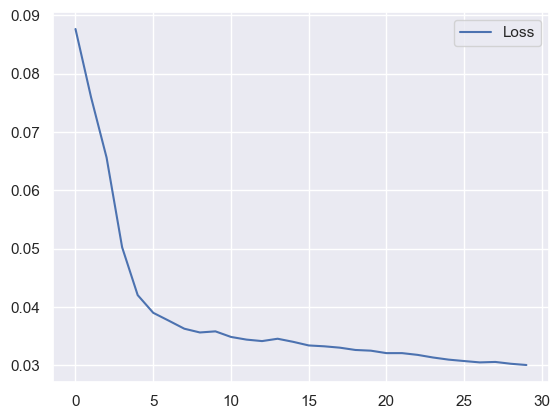

In [96]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [97]:
y_hat = model.predict(x_test)

2023-06-29 01:10:02.985046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:03.074744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 2s 3ms/step


In [98]:
y_hat.shape,y_test.shape


((12673, 1), (12673,))

In [99]:
#  y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_hat][1:]),len(y_test[:-1])  


(12672, 12672)

In [100]:
y_hat_modified = [i[0] for i in y_hat][2:]  # discarding the first two elements
y_test_modified = y_test[:-2]  # discarding the last two elements

print(len(y_hat_modified), len(y_test_modified))  # check if lengths are now the same

pa = pd.DataFrame()
pa['Month'] = X_test.reset_index().month.iloc[2:-2]  # also adjusted here
pa['Year'] = X_test.reset_index().year.iloc[2:-2]  # and here
pa['Prediction'] = y_hat_modified
pa['Actual Values'] = y_test_modified
pa.head()


12671 12671


,Month,Year,Prediction,Actual Values
2,3,2018,0.123083,0.0
3,4,2018,0.123001,0.0
4,5,2018,0.123533,0.0
5,6,2018,0.123019,0.0
6,7,2018,0.122779,0.0


In [101]:
pa['Actual Values'].sum()

1271.0

## Interpretation

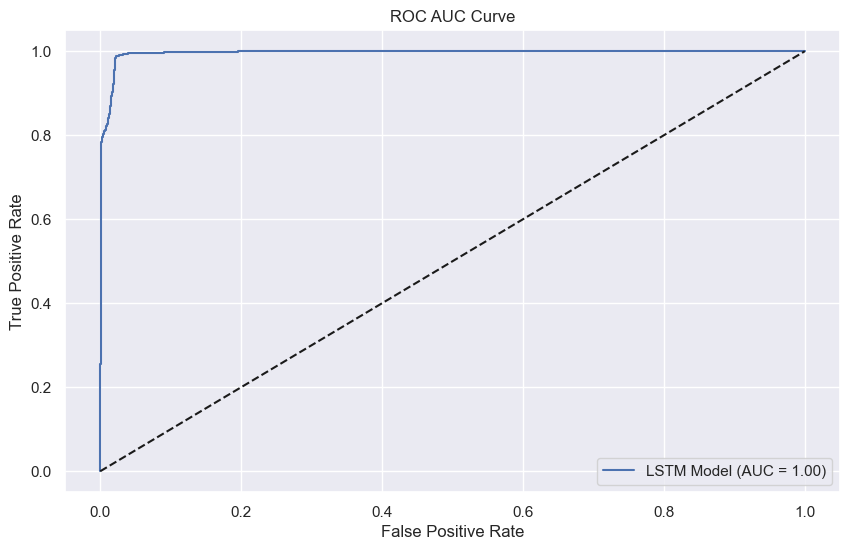

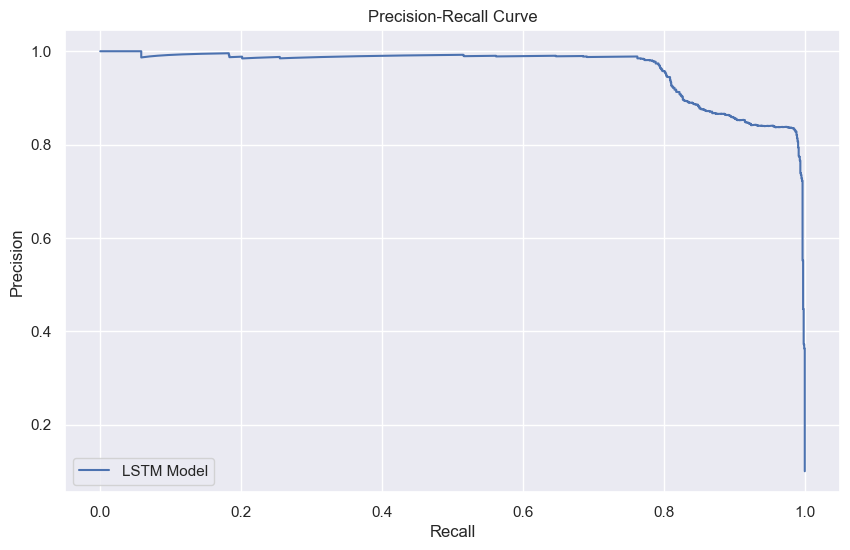

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values


# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [103]:
thresholds

array([0.01007933, 0.0113718 , 0.01178567, ..., 0.95226854, 0.95438325,
       0.9625331 ], dtype=float32)

In [104]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# classes
y_pred_classes = (pa['Prediction'].values > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(pa['Actual Values'].values, y_pred_classes))

print("\nClassification Report:\n", classification_report(pa['Actual Values'].values, y_pred_classes))

roc_auc_minority = roc_auc_score(pa['Actual Values'].values == 1, y_pred_classes)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[11151   249]
 [   19  1252]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11400
         1.0       0.83      0.99      0.90      1271

    accuracy                           0.98     12671
   macro avg       0.92      0.98      0.95     12671
weighted avg       0.98      0.98      0.98     12671


ROC AUC for minority class: 0.9816045177854156


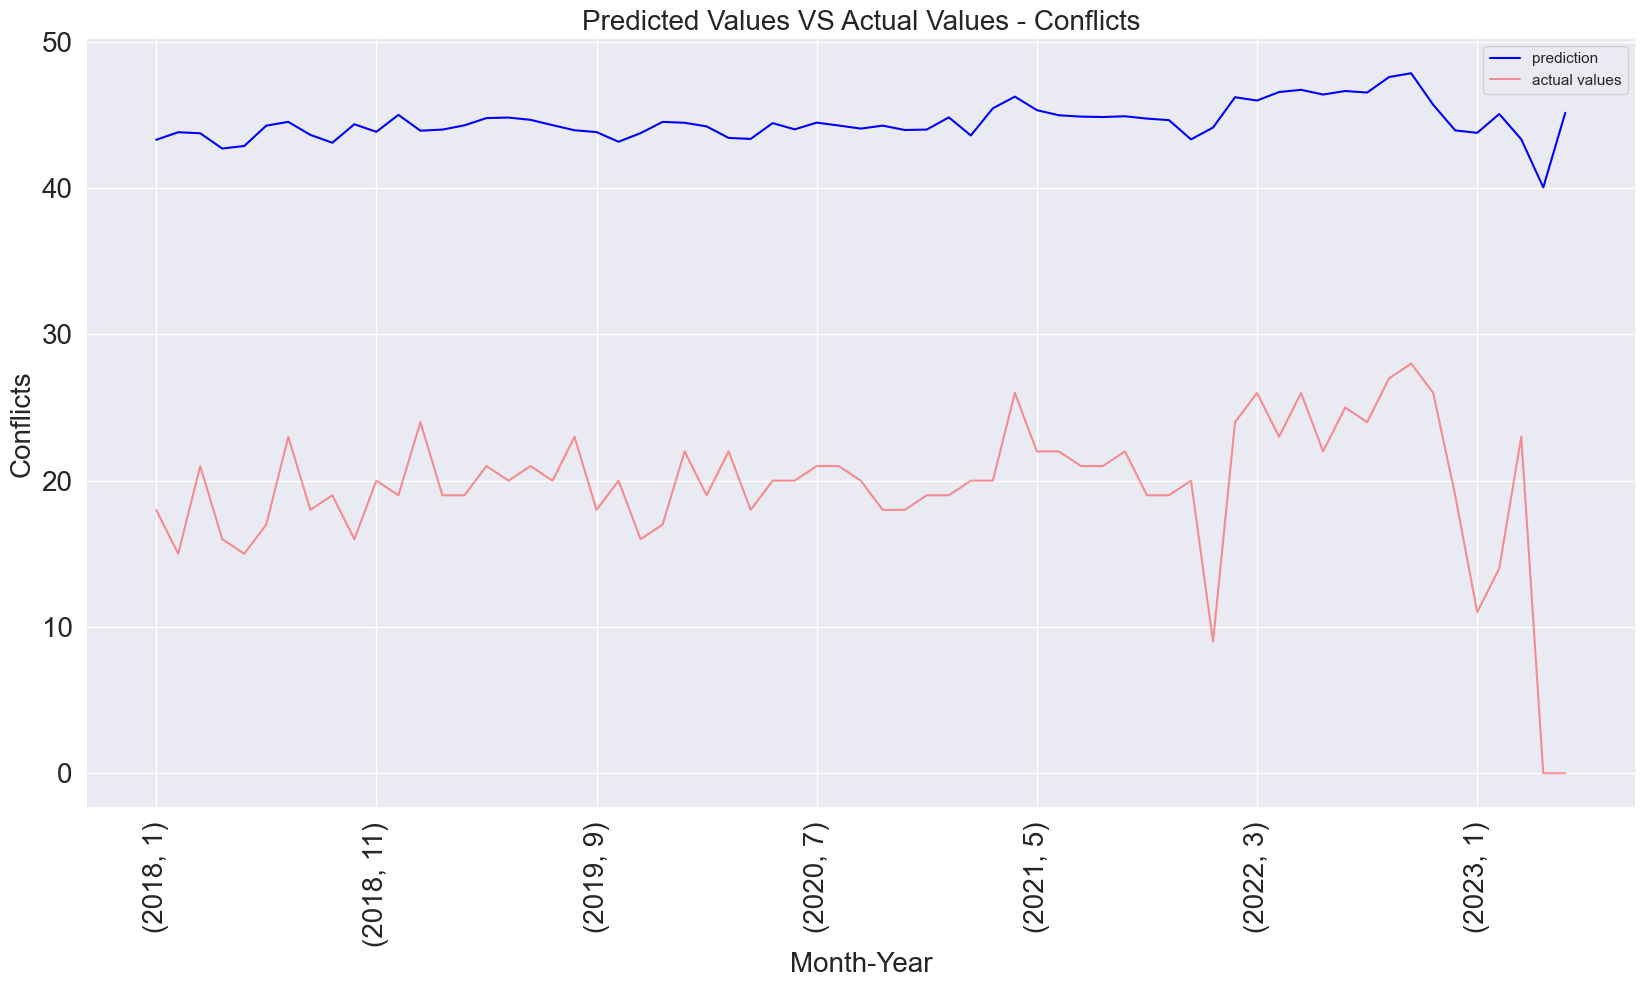

In [105]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='blue', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='red', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [106]:
conf.columns

Index(['deaths', 'wb_pop', 'total_events', 'total_events_gov',
       'total_events_opp', 'share_events_count_events_1',
       'share_events_count_events_2', 'share_events_count_events_3',
       'share_events_count_events_4', 'share_events_count_events_5',
       'share_events_count_events_6', 'share_events_count_events_7',
       'share_events_count_events_8', 'share_events_count_events_9',
       'share_events_count_events_10', 'share_events_count_events_11',
       'share_events_count_events_12', 'share_events_count_events_13',
       'share_events_count_events_14', 'share_events_count_events_15',
       'share_events_count_events_16', 'share_events_count_events_17',
       'share_events_count_events_18', 'share_events_count_events_19',
       'share_events_count_events_20', 'share_events_count_events_1_gov',
       'share_events_count_events_2_gov', 'share_events_count_events_3_gov',
       'share_events_count_events_4_gov', 'share_events_count_events_5_gov',
       'share_events

In [107]:
df_final.month_year

25128    2000-01-01
25129    2000-01-01
25130    2000-01-01
25131    2000-01-01
25132    2000-01-01
            ...    
79870    2023-05-01
79871    2023-05-01
79872    2023-05-01
79873    2023-05-01
79874    2023-05-01
Name: month_year, Length: 54747, dtype: object

In [108]:
conf

,,,deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,year,month,,,,,,,,,,,,,,,,,,,,,
AFG,2000,1,0.002054,0.013818,0.001234,0.001357,0.001280,0.114855,0.045559,0.072741,0.346861,0.089969,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,2000,1,0.001370,0.011588,0.001280,0.001977,0.002246,0.131365,0.042804,0.085240,0.254982,0.052768,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,2000,1,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,0.046041,0.081400,0.275875,0.060037,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,2000,1,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,0.026585,0.065440,0.533742,0.051125,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,2000,1,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,0.053790,0.114914,0.418093,0.060310,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,2023,5,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,0.076923,0.089231,0.307692,0.190769,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,2023,5,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,0.046456,0.054199,0.406194,0.107802,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,2023,5,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,0.068819,0.066460,0.250162,0.075432,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


In [109]:
df_final

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
25128,1970-01-01 00:00:00.000200001,AFG,1,2000,54.0,54.0,0.0,0.0,26.0,2000-01-01,...,16.706907,22.972855,180.652765,346.465884,0,32,629.252033,582.202685,578.869009,Afghanistan
25129,1970-01-01 00:00:00.000200001,AGO,1,2000,36.0,0.0,0.0,36.0,36.0,2000-01-01,...,5.984914,17.017786,27.334553,185.535914,0,20,189.309091,126.144306,129.261468,Angola
25130,1970-01-01 00:00:00.000200001,ALB,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.193002,0.193002,0.193002,9,14,0.060606,0.039237,0.036156,Albania
25131,1970-01-01 00:00:00.000200001,ARE,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.000000,0.000000,0.000000,133,8,0.012346,0.007773,0.007618,United Arab Emirates
25132,1970-01-01 00:00:00.000200001,ARG,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.000000,0.000000,0.249357,66,19,1.535714,0.295357,0.125364,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79870,1970-01-01 00:00:00.000202305,XKX,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,412,10,0.000000,0.000000,0.000000,Kosovo
79871,1970-01-01 00:00:00.000202305,YEM,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.927789,2.416496,101.723726,162.727194,2,20,200.276596,121.436293,118.934417,"Yemen, Rep."
79872,1970-01-01 00:00:00.000202305,ZAF,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.010102,0.102890,0.108207,22,11,14.751497,12.100576,13.784257,South Africa
79873,1970-01-01 00:00:00.000202305,ZMB,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,258,11,0.120482,0.065602,0.060748,Zambia


In [110]:
df_final.set_index(['isocode', 'month', 'year'], inplace=True)


In [111]:
armedconfdf.set_index(['isocode', 'month', 'year'], inplace=True)

In [112]:
country

['Sao Tome and Principe',
 'Senegal',
 'Uganda',
 'Bolivia',
 'Algeria',
 'Netherlands',
 'Gibraltar',
 'Iceland',
 'Jamaica',
 'Kosovo',
 'Iran, Islamic Rep.',
 'Mongolia',
 'Timor-Leste',
 'Austria',
 'Croatia',
 'Qatar',
 'Syrian Arab Republic',
 'Thailand',
 'Spain',
 'Trinidad and Tobago',
 'Hungary',
 'Guyana',
 'Cambodia',
 'Togo',
 'Australia',
 'Fiji',
 'Afghanistan',
 'Oman',
 'Chad',
 'Bhutan',
 'Philippines',
 'Korea, Rep.',
 'Dominica',
 'Bahamas, The',
 'Mauritania',
 'Norway',
 'West Bank and Gaza',
 'Maldives',
 'Costa Rica',
 'Papua New Guinea',
 'Ghana',
 'Hong Kong SAR, China',
 'Indonesia',
 'Argentina',
 'Russian Federation',
 'Comoros',
 'United Kingdom',
 'Congo, Rep.',
 'Canada',
 'Kazakhstan',
 'Mali',
 'Tonga',
 'Serbia',
 'Montenegro',
 'Solomon Islands',
 'Jordan',
 'Malawi',
 'Ethiopia',
 'France',
 'Germany',
 'Romania',
 'Azerbaijan',
 'Monaco',
 'Djibouti',
 'Benin',
 'Ireland',
 'Saudi Arabia',
 'Italy',
 'Slovenia',
 'Turkiye',
 'Vietnam',
 'Venezuela,

In [113]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['armedconf','country','month_year']))
    # create datefrane fir scaled data
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['armedconf','country','month_year']).columns, index=country.index)
    scaled_df['armedconf']=list(country.armedconf)
    X_train, X_test,Y_train,Y_test=train_test_split_year(scaled_df, 2018)
    #combine x train and y train as train data 
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['armedconf']=Y_train
    #combine x test and y test as test data 
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['armedconf']=Y_test

    # using the function to obtian reshaped x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test, _ =reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

In [114]:
scaled_df

,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,...,deaths_state_pc,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,0.002054,0.002117,0.0,0.000000,0.001888,0.013818,0.001234,0.001357,0.001280,0.114855,...,0.004603,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220
1,0.001370,0.000000,0.0,0.012312,0.002614,0.011588,0.001280,0.001977,0.002246,0.131365,...,0.003658,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612
2,0.000000,0.000000,0.0,0.000000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,...,0.000000,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020
3,0.000000,0.000000,0.0,0.000000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004
4,0.000000,0.000000,0.0,0.000000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,...,0.000000,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54742,0.000000,0.000000,0.0,0.000000,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000
54743,0.000000,0.000000,0.0,0.000000,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,...,0.000000,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971
54744,0.000000,0.000000,0.0,0.000000,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,...,0.000000,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530
54745,0.000000,0.000000,0.0,0.000000,0.000000,0.013768,0.000620,0.000917,0.000042,0.146992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.624697,0.042918,0.000046,0.000034,0.000033


In [115]:
armedconfdf.to_csv('armedconfdf.csv')

Epoch 1/30


2023-06-29 01:10:08.576971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:08.802368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 5s - loss: 0.2153 - accuracy: 0.8200 - recall_13: 0.8723

2023-06-29 01:10:09.237969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 105ms/step - loss: 0.1523 - accuracy: 0.9579 - recall_13: 0.9716
Epoch 2/30
5/5 [==============================] - 0s 50ms/step - loss: 0.0387 - accuracy: 0.9860 - recall_13: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 22ms/step - loss: 0.0168 - accuracy: 0.9860 - recall_13: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 32ms/step - loss: 0.0141 - accuracy: 0.9860 - recall_13: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 21ms/step - loss: 0.0145 - accuracy: 0.9860 - recall_13: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 30ms/step - loss: 0.0150 - accuracy: 0.9860 - recall_13: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0152 - accuracy: 0.9860 - recall_13: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0152 - accuracy: 0.9860 - recall_13: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0

2023-06-29 01:10:12.363730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:12.418802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Afghanistan - Precision: 0.9047619047619048


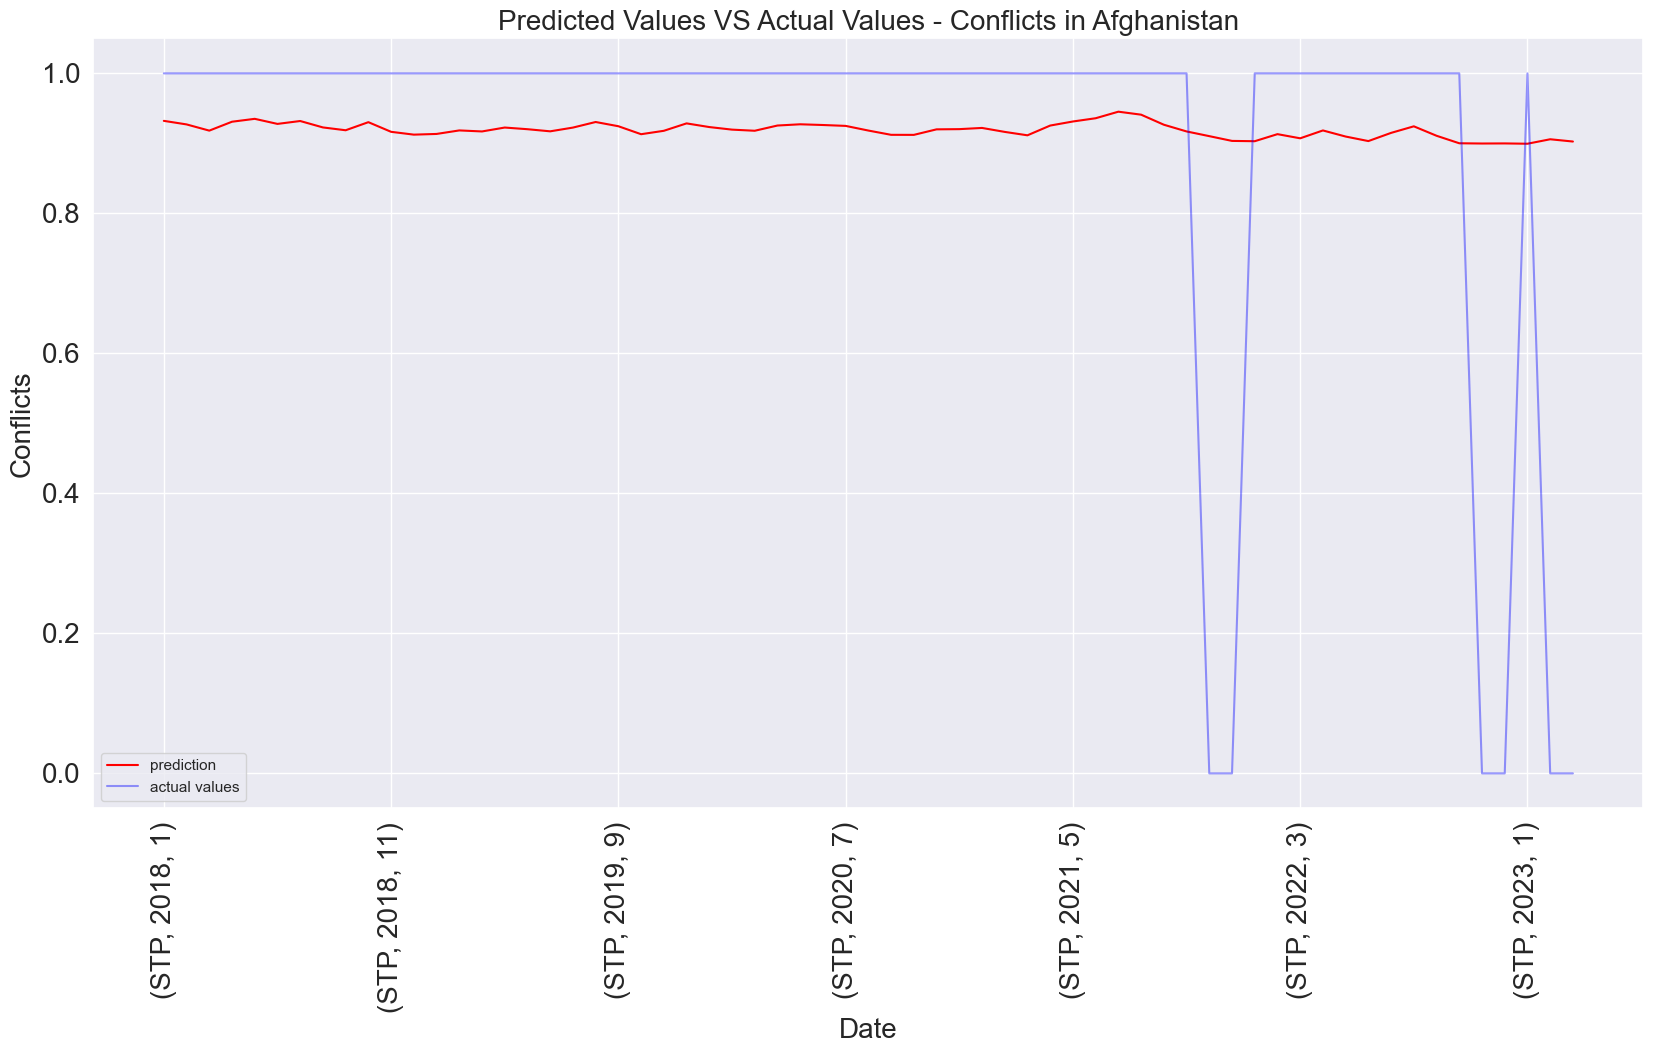

Epoch 1/30


2023-06-29 01:10:13.950692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:14.178942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 7s - loss: 2.5232 - accuracy: 0.6000 - recall_14: 0.7179

2023-06-29 01:10:14.545985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 124ms/step - loss: 1.9141 - accuracy: 0.8692 - recall_14: 0.9388
Epoch 2/30
5/5 [==============================] - 0s 51ms/step - loss: 0.7398 - accuracy: 0.9159 - recall_14: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 33ms/step - loss: 0.5714 - accuracy: 0.9159 - recall_14: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 26ms/step - loss: 0.6139 - accuracy: 0.9159 - recall_14: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 21ms/step - loss: 0.6497 - accuracy: 0.9159 - recall_14: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 17ms/step - loss: 0.6480 - accuracy: 0.9159 - recall_14: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 13ms/step - loss: 0.6222 - accuracy: 0.9159 - recall_14: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.5893 - accuracy: 0.9159 - recall_14: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 12ms/step - loss: 0.5

2023-06-29 01:10:17.656794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:17.706463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Somalia - Precision: 0.9523809523809523


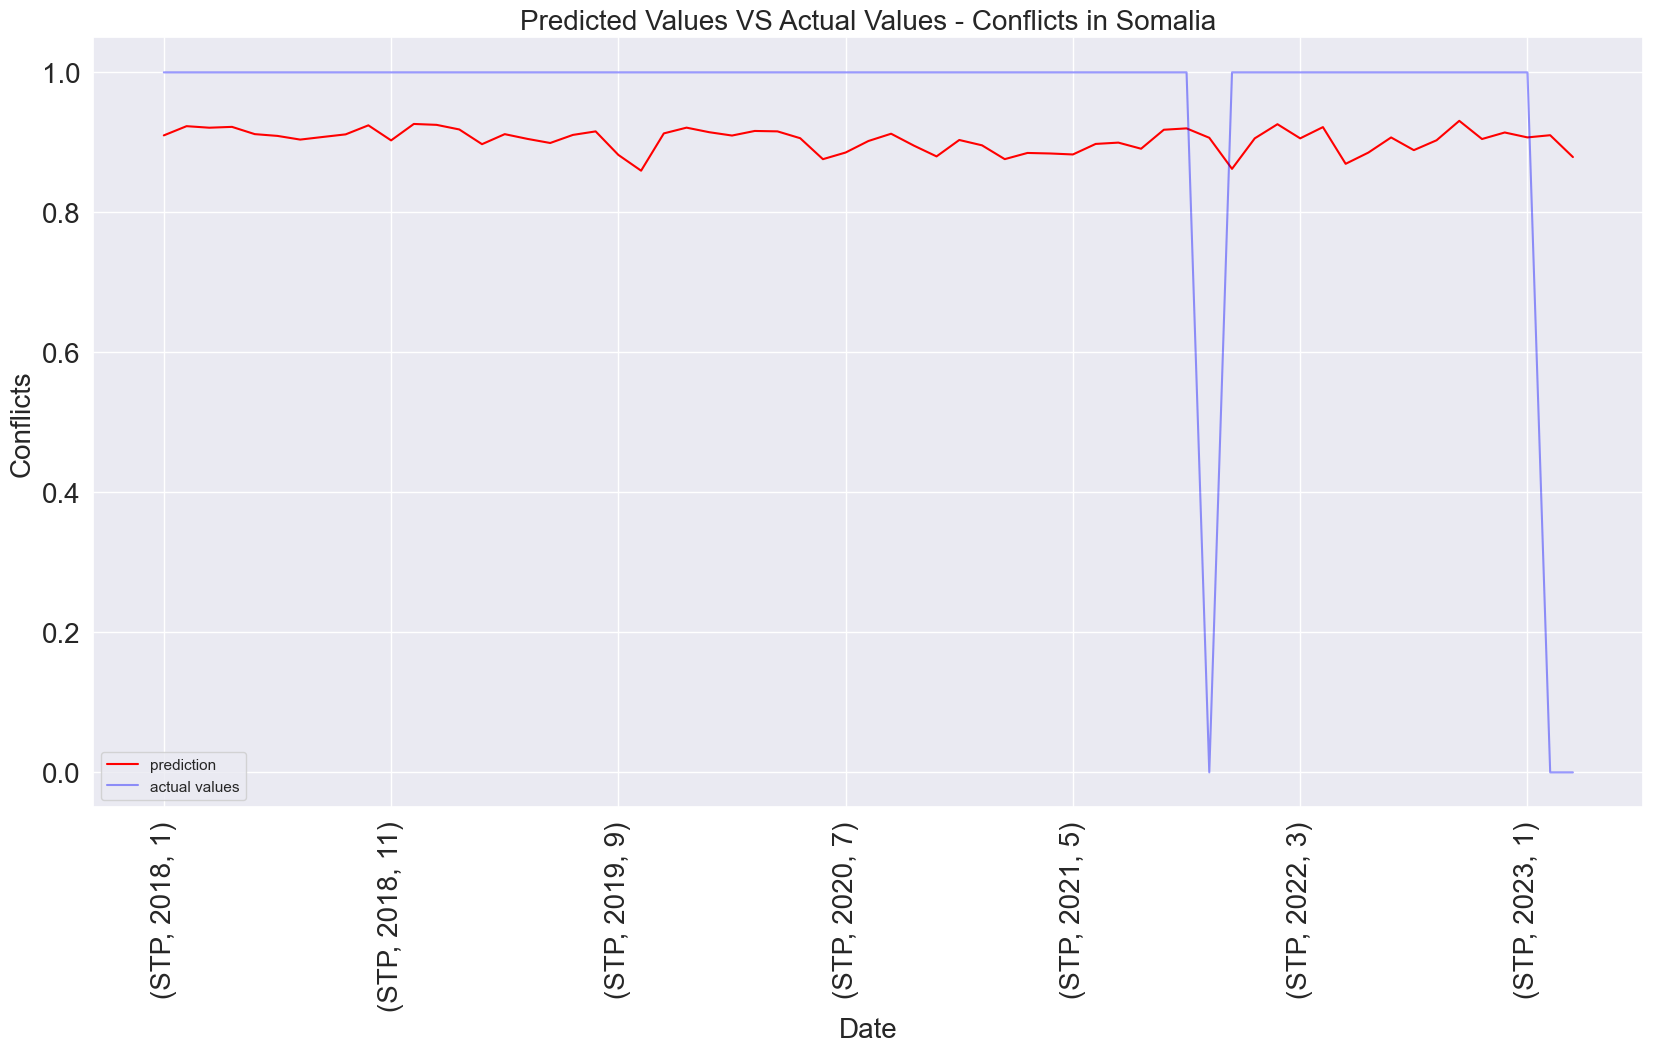

Epoch 1/30


2023-06-29 01:10:18.567371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:18.759131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.6534 - accuracy: 0.4800 - recall_15: 0.4000

2023-06-29 01:10:19.138216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 118ms/step - loss: 0.9486 - accuracy: 0.8131 - recall_15: 0.8851
Epoch 2/30
5/5 [==============================] - 0s 34ms/step - loss: 0.4202 - accuracy: 0.8131 - recall_15: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 26ms/step - loss: 0.3636 - accuracy: 0.8131 - recall_15: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 35ms/step - loss: 0.3931 - accuracy: 0.8131 - recall_15: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 16ms/step - loss: 0.3983 - accuracy: 0.8131 - recall_15: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 18ms/step - loss: 0.3747 - accuracy: 0.8131 - recall_15: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 16ms/step - loss: 0.3387 - accuracy: 0.8131 - recall_15: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 12ms/step - loss: 0.3032 - accuracy: 0.8131 - recall_15: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 16ms/step - loss: 0.2

2023-06-29 01:10:22.257190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:22.307133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Iraq - Precision: 0.9206349206349206


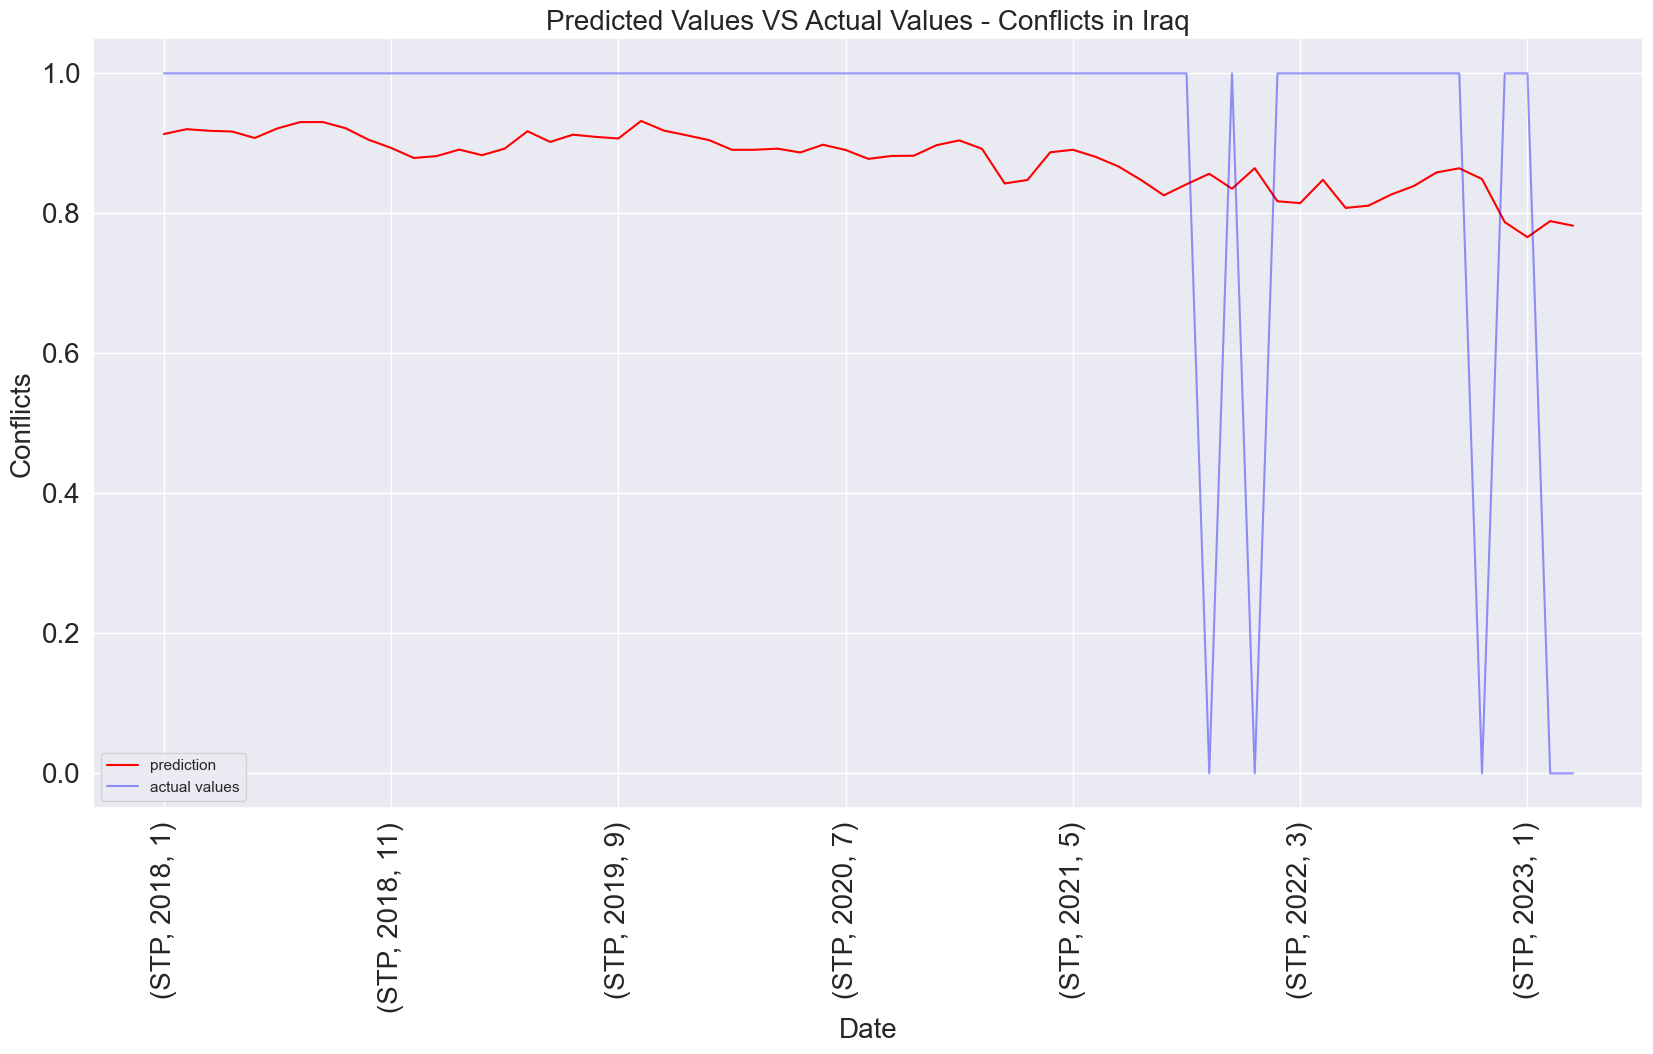

Epoch 1/30


2023-06-29 01:10:23.167432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:23.362897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.2414 - accuracy: 0.7800 - recall_16: 0.8810

2023-06-29 01:10:23.752920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 115ms/step - loss: 0.1834 - accuracy: 0.8458 - recall_16: 0.9728
Epoch 2/30
5/5 [==============================] - 0s 50ms/step - loss: 0.0974 - accuracy: 0.8598 - recall_16: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 44ms/step - loss: 0.0944 - accuracy: 0.8598 - recall_16: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 24ms/step - loss: 0.0948 - accuracy: 0.8598 - recall_16: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 21ms/step - loss: 0.0918 - accuracy: 0.8598 - recall_16: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0907 - accuracy: 0.8598 - recall_16: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0918 - accuracy: 0.8598 - recall_16: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0924 - accuracy: 0.8598 - recall_16: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0

2023-06-29 01:10:26.943184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:26.995898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sudan - Precision: 0.5714285714285714


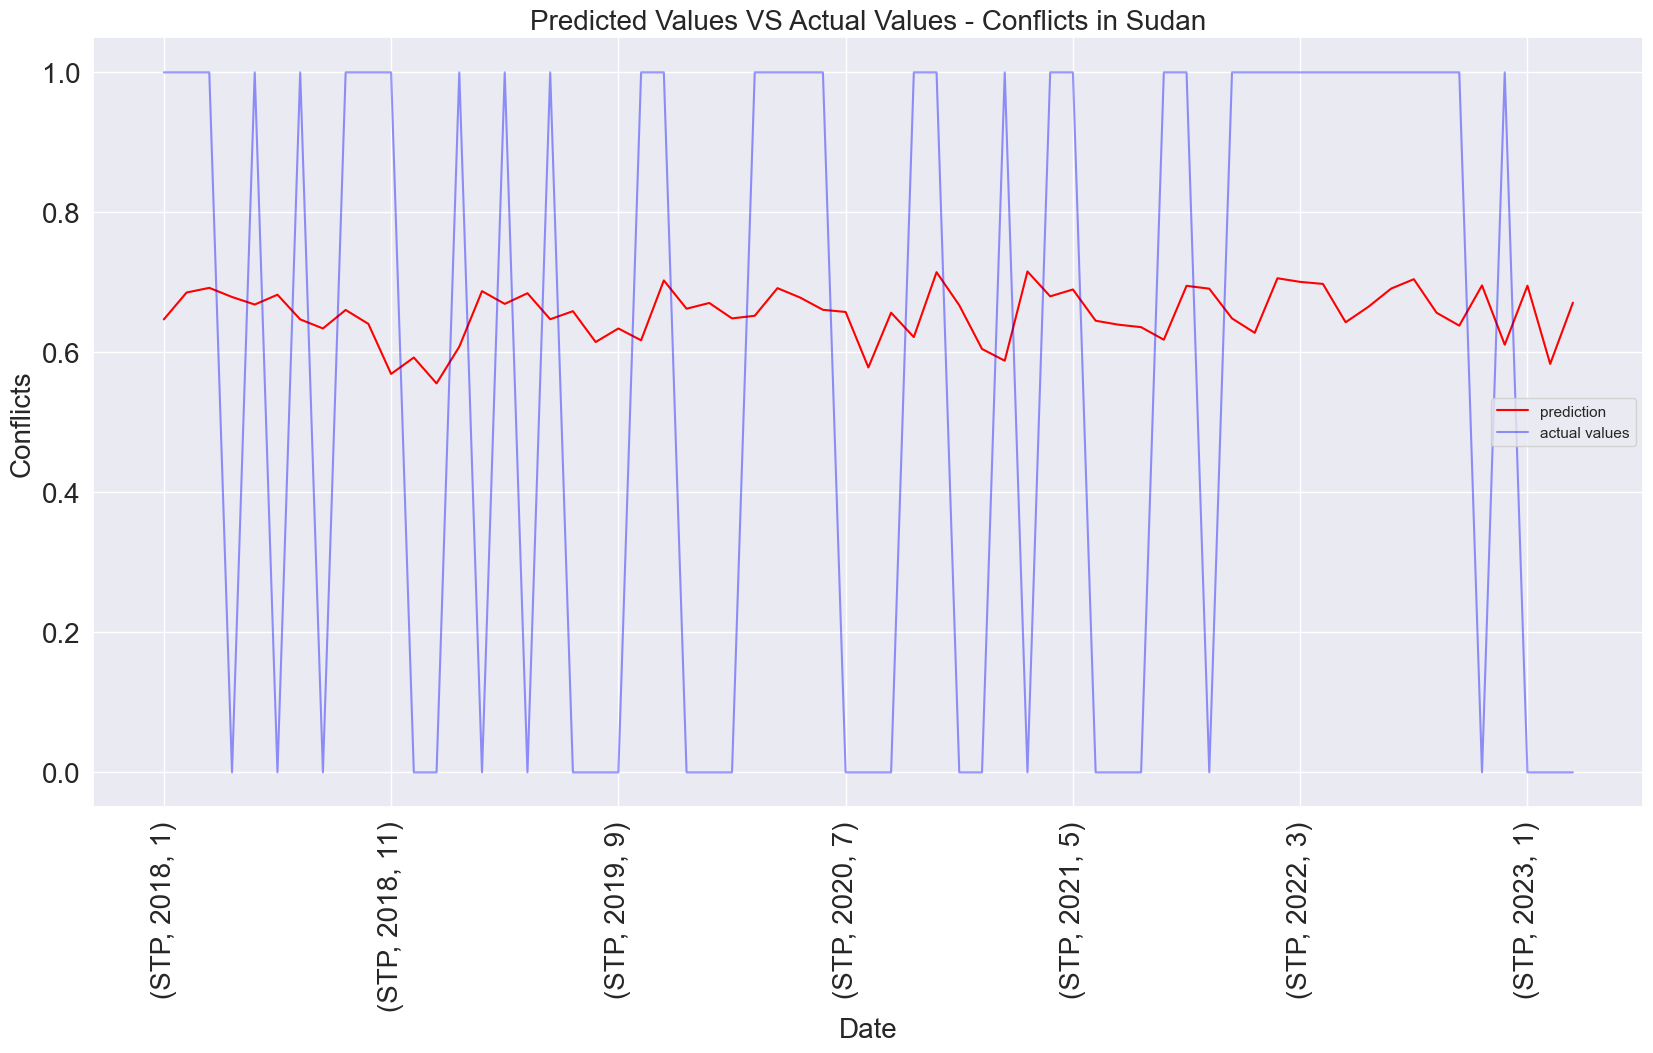

Epoch 1/30


2023-06-29 01:10:28.450268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:28.715918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 7s - loss: 0.2824 - accuracy: 0.7800 - recall_17: 0.9250

2023-06-29 01:10:29.091401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 123ms/step - loss: 0.2257 - accuracy: 0.7009 - recall_17: 0.9737
Epoch 2/30
5/5 [==============================] - 0s 41ms/step - loss: 0.1675 - accuracy: 0.7103 - recall_17: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 39ms/step - loss: 0.1786 - accuracy: 0.7103 - recall_17: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 20ms/step - loss: 0.1810 - accuracy: 0.7103 - recall_17: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 31ms/step - loss: 0.1717 - accuracy: 0.7103 - recall_17: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.1629 - accuracy: 0.7103 - recall_17: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 14ms/step - loss: 0.1585 - accuracy: 0.7103 - recall_17: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 17ms/step - loss: 0.1560 - accuracy: 0.7103 - recall_17: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 17ms/step - loss: 0.1

2023-06-29 01:10:32.336313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:32.386688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Congo, Dem. Rep. - Precision: 0.9365079365079365


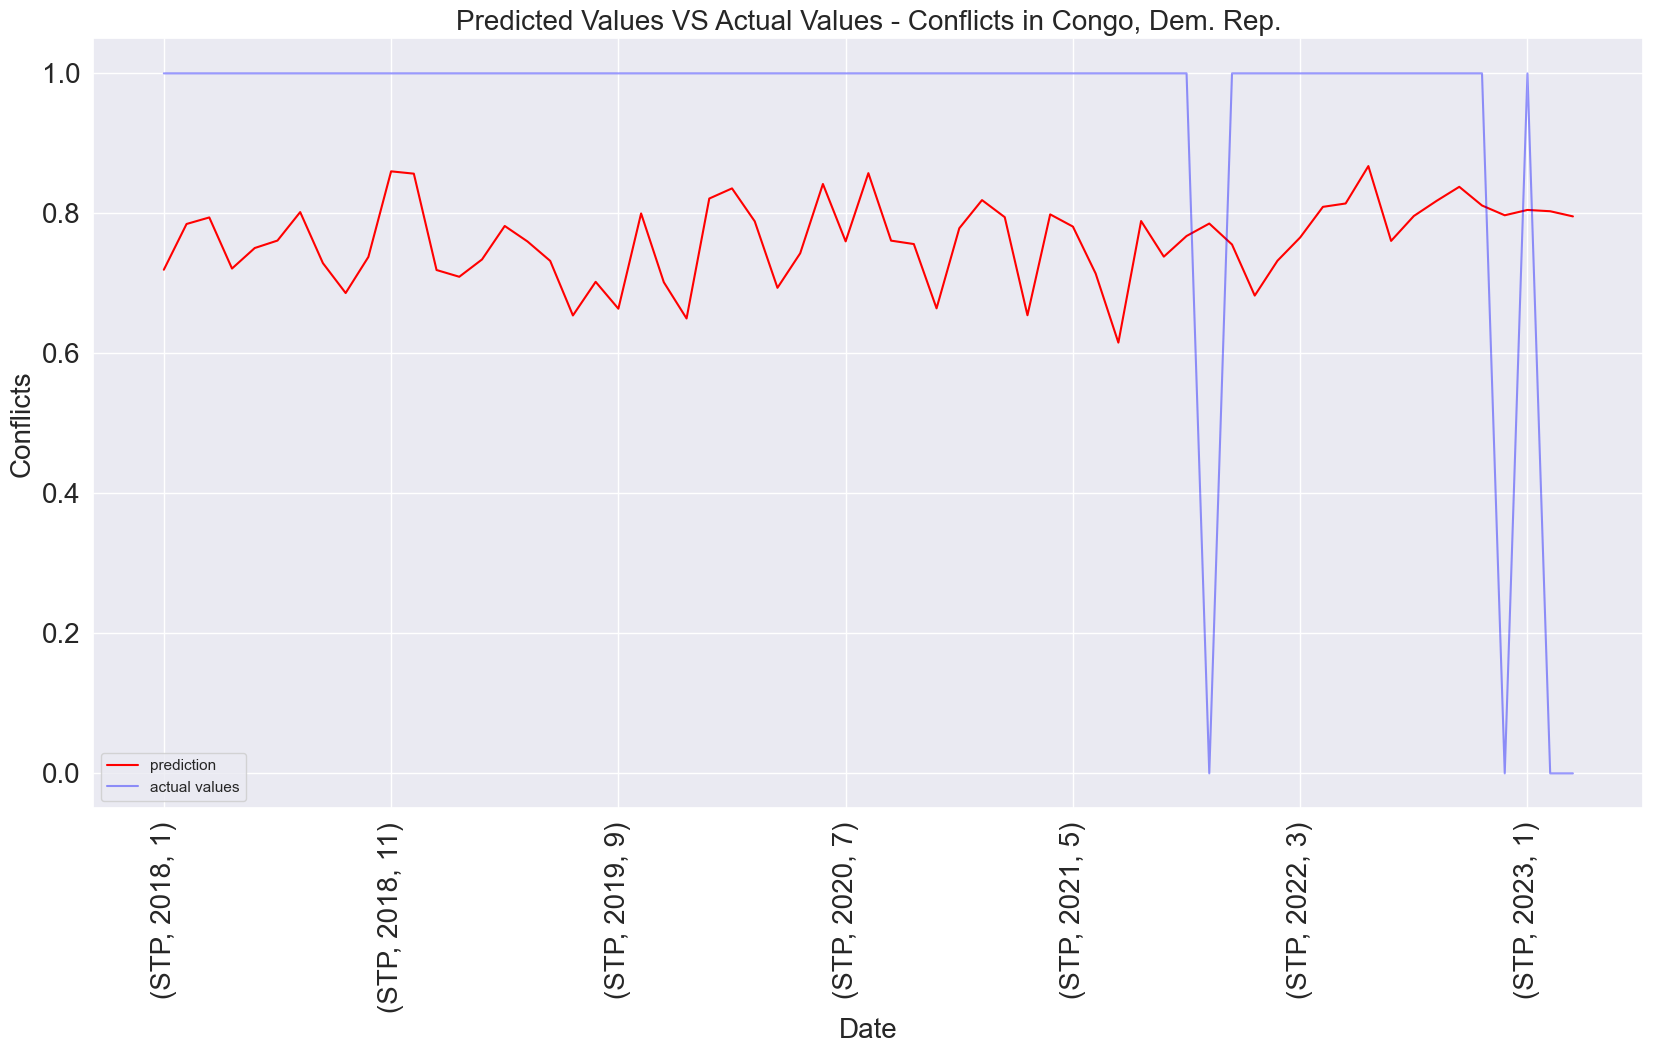

Epoch 1/30


2023-06-29 01:10:33.240814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:33.427521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.2283 - accuracy: 0.5400 - recall_18: 0.8571

2023-06-29 01:10:33.795993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 133ms/step - loss: 0.3812 - accuracy: 0.5841 - recall_18: 0.4649
Epoch 2/30
5/5 [==============================] - 0s 37ms/step - loss: 0.2718 - accuracy: 0.5748 - recall_18: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 46ms/step - loss: 0.2551 - accuracy: 0.5327 - recall_18: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 20ms/step - loss: 0.2689 - accuracy: 0.5327 - recall_18: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 17ms/step - loss: 0.2739 - accuracy: 0.5327 - recall_18: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 21ms/step - loss: 0.2645 - accuracy: 0.5327 - recall_18: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 17ms/step - loss: 0.2497 - accuracy: 0.5327 - recall_18: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 24ms/step - loss: 0.2362 - accuracy: 0.5374 - recall_18: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 12ms/step - loss: 0.2

2023-06-29 01:10:36.972096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:37.022410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Central African Republic - Precision: 0.9047619047619048


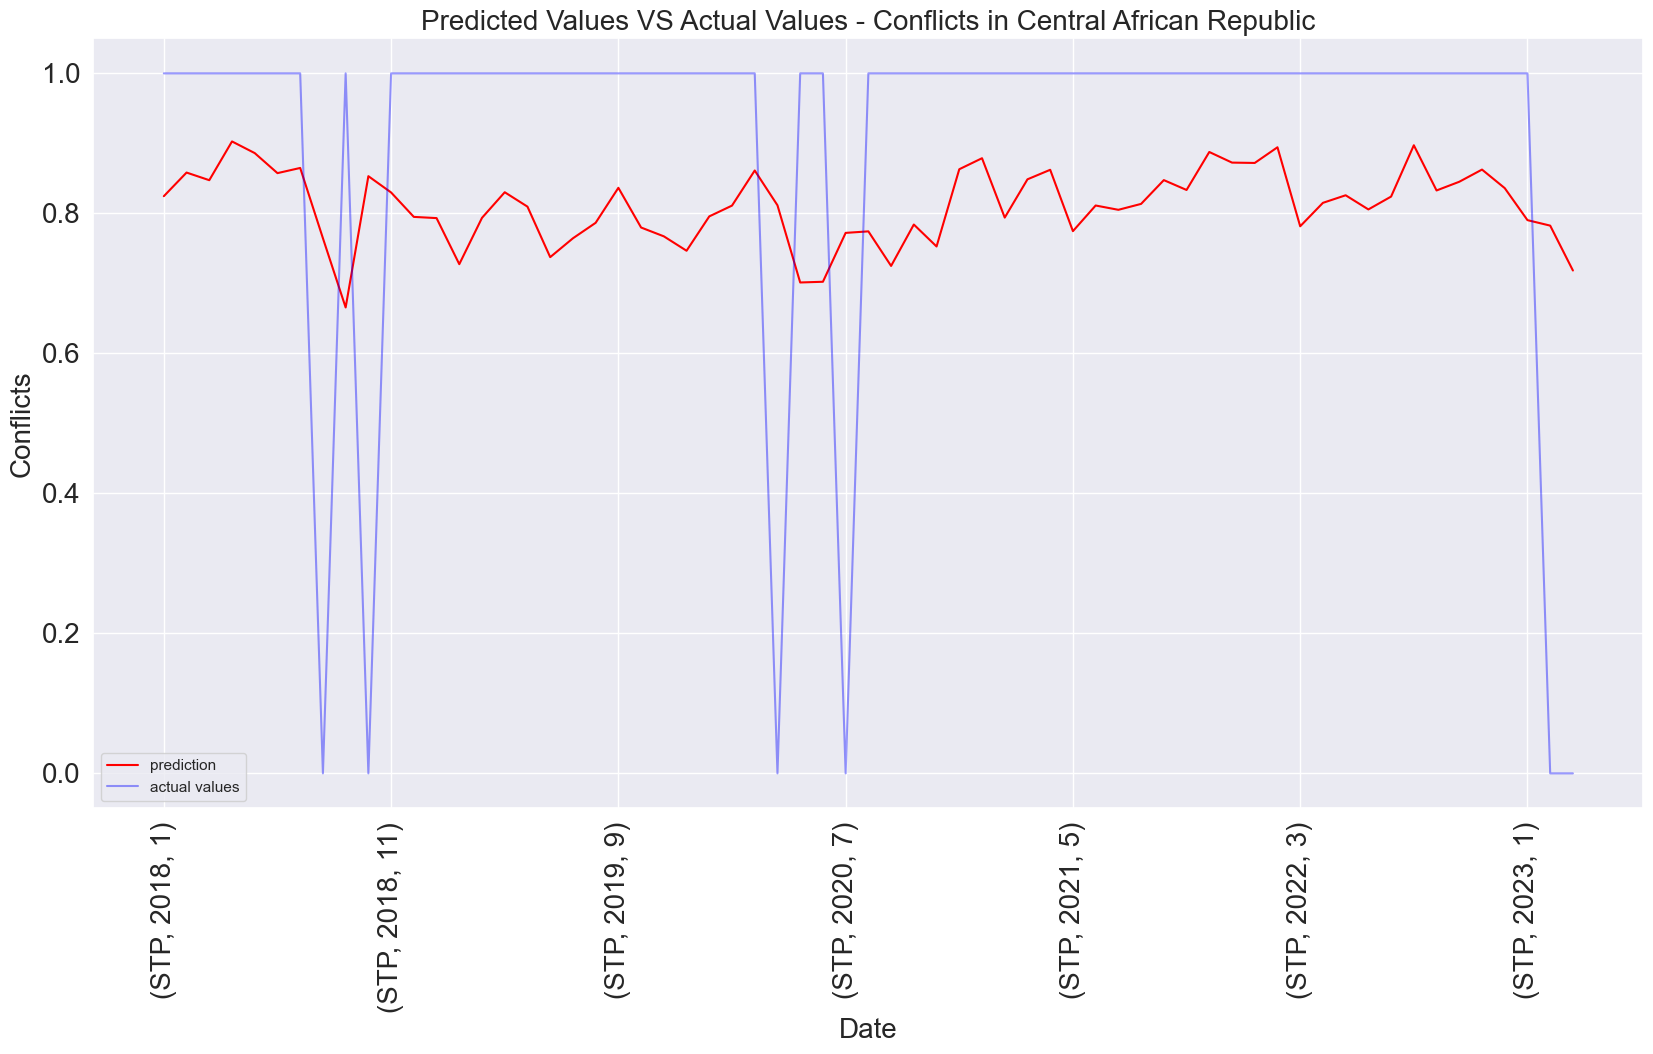

Epoch 1/30


2023-06-29 01:10:37.862388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:38.055384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.2379 - accuracy: 0.4800 - recall_19: 1.0000

2023-06-29 01:10:38.420316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 128ms/step - loss: 0.3248 - accuracy: 0.4579 - recall_19: 0.3939
Epoch 2/30
5/5 [==============================] - 0s 49ms/step - loss: 0.2345 - accuracy: 0.4813 - recall_19: 0.9899
Epoch 3/30
5/5 [==============================] - 0s 33ms/step - loss: 0.2439 - accuracy: 0.4626 - recall_19: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 40ms/step - loss: 0.2596 - accuracy: 0.4626 - recall_19: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 17ms/step - loss: 0.2488 - accuracy: 0.4626 - recall_19: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.2274 - accuracy: 0.4626 - recall_19: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 20ms/step - loss: 0.2097 - accuracy: 0.4766 - recall_19: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 20ms/step - loss: 0.1970 - accuracy: 0.5093 - recall_19: 0.9798
Epoch 9/30
5/5 [==============================] - 0s 14ms/step - loss: 0.1

2023-06-29 01:10:41.598429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:41.646901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Nigeria - Precision: 0.8888888888888888


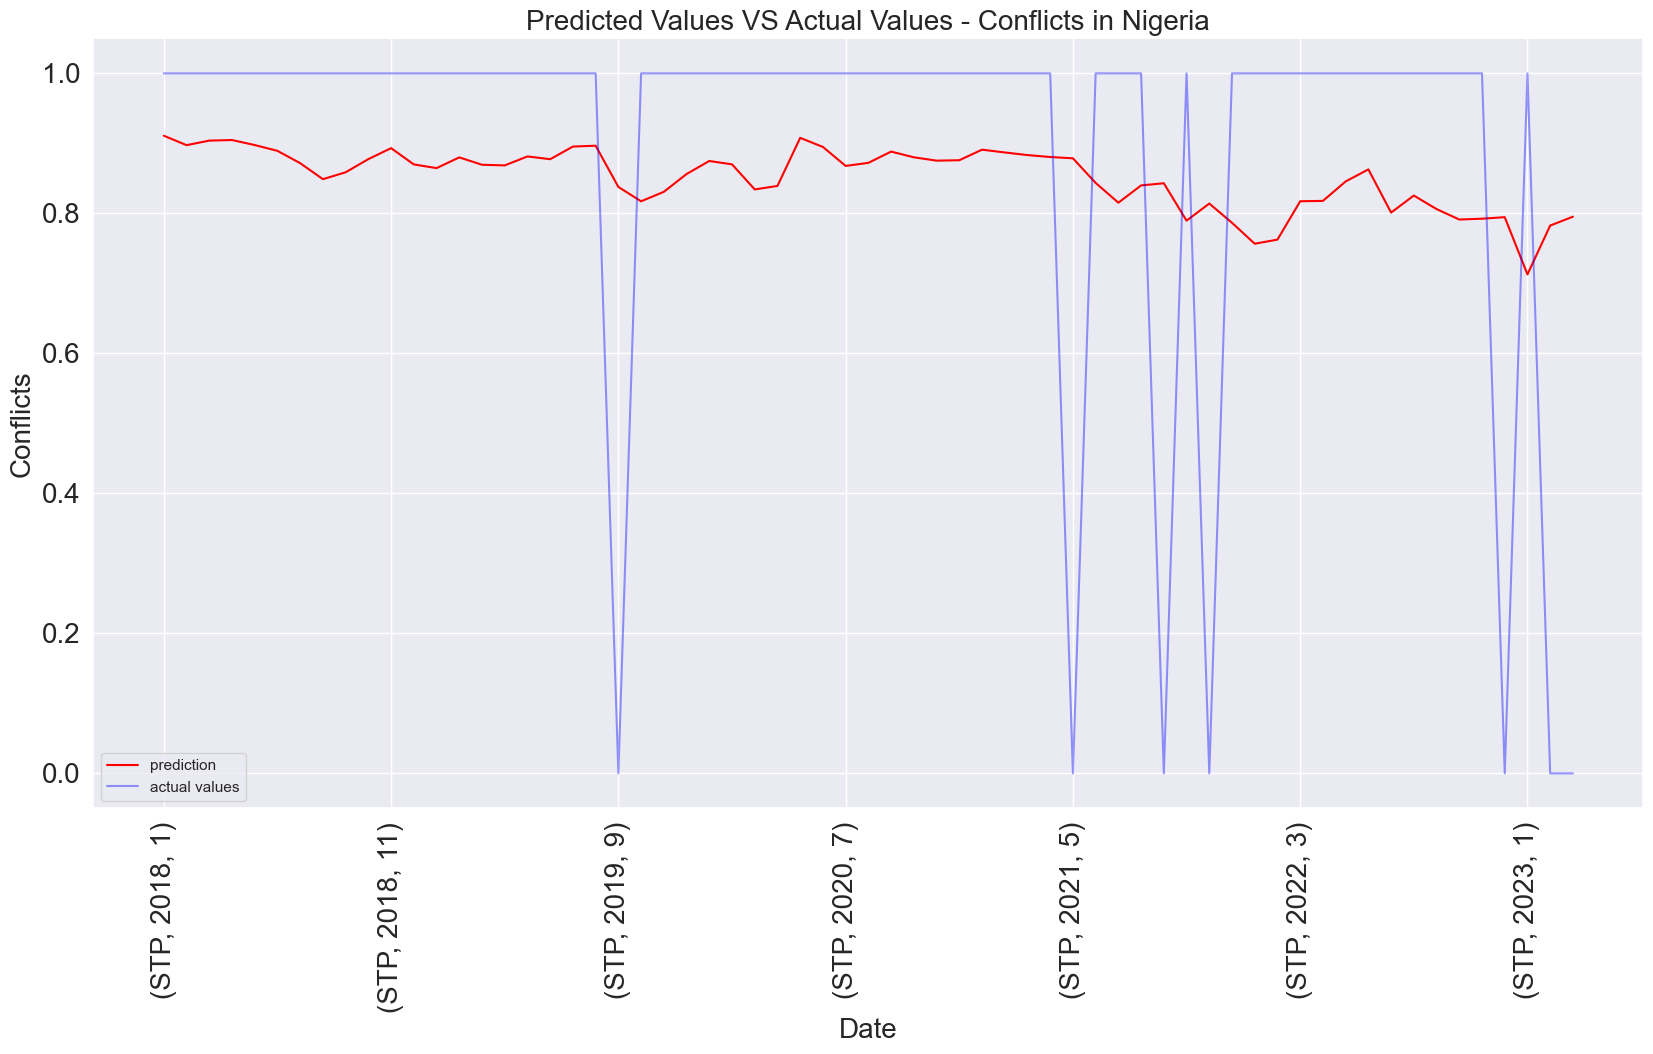

Epoch 1/30


2023-06-29 01:10:43.201470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:43.416998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.5062 - accuracy: 0.8200 - recall_20: 0.9318

2023-06-29 01:10:43.799708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 122ms/step - loss: 0.3821 - accuracy: 0.6121 - recall_20: 0.9776
Epoch 2/30
5/5 [==============================] - 0s 51ms/step - loss: 0.2699 - accuracy: 0.6262 - recall_20: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 32ms/step - loss: 0.2479 - accuracy: 0.6262 - recall_20: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 24ms/step - loss: 0.2315 - accuracy: 0.6262 - recall_20: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 22ms/step - loss: 0.2237 - accuracy: 0.6262 - recall_20: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 32ms/step - loss: 0.2223 - accuracy: 0.6262 - recall_20: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 19ms/step - loss: 0.2186 - accuracy: 0.6308 - recall_20: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 12ms/step - loss: 0.2097 - accuracy: 0.6308 - recall_20: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 13ms/step - loss: 0.1

2023-06-29 01:10:46.979133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:47.029523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Israel - Precision: 0.36363636363636365


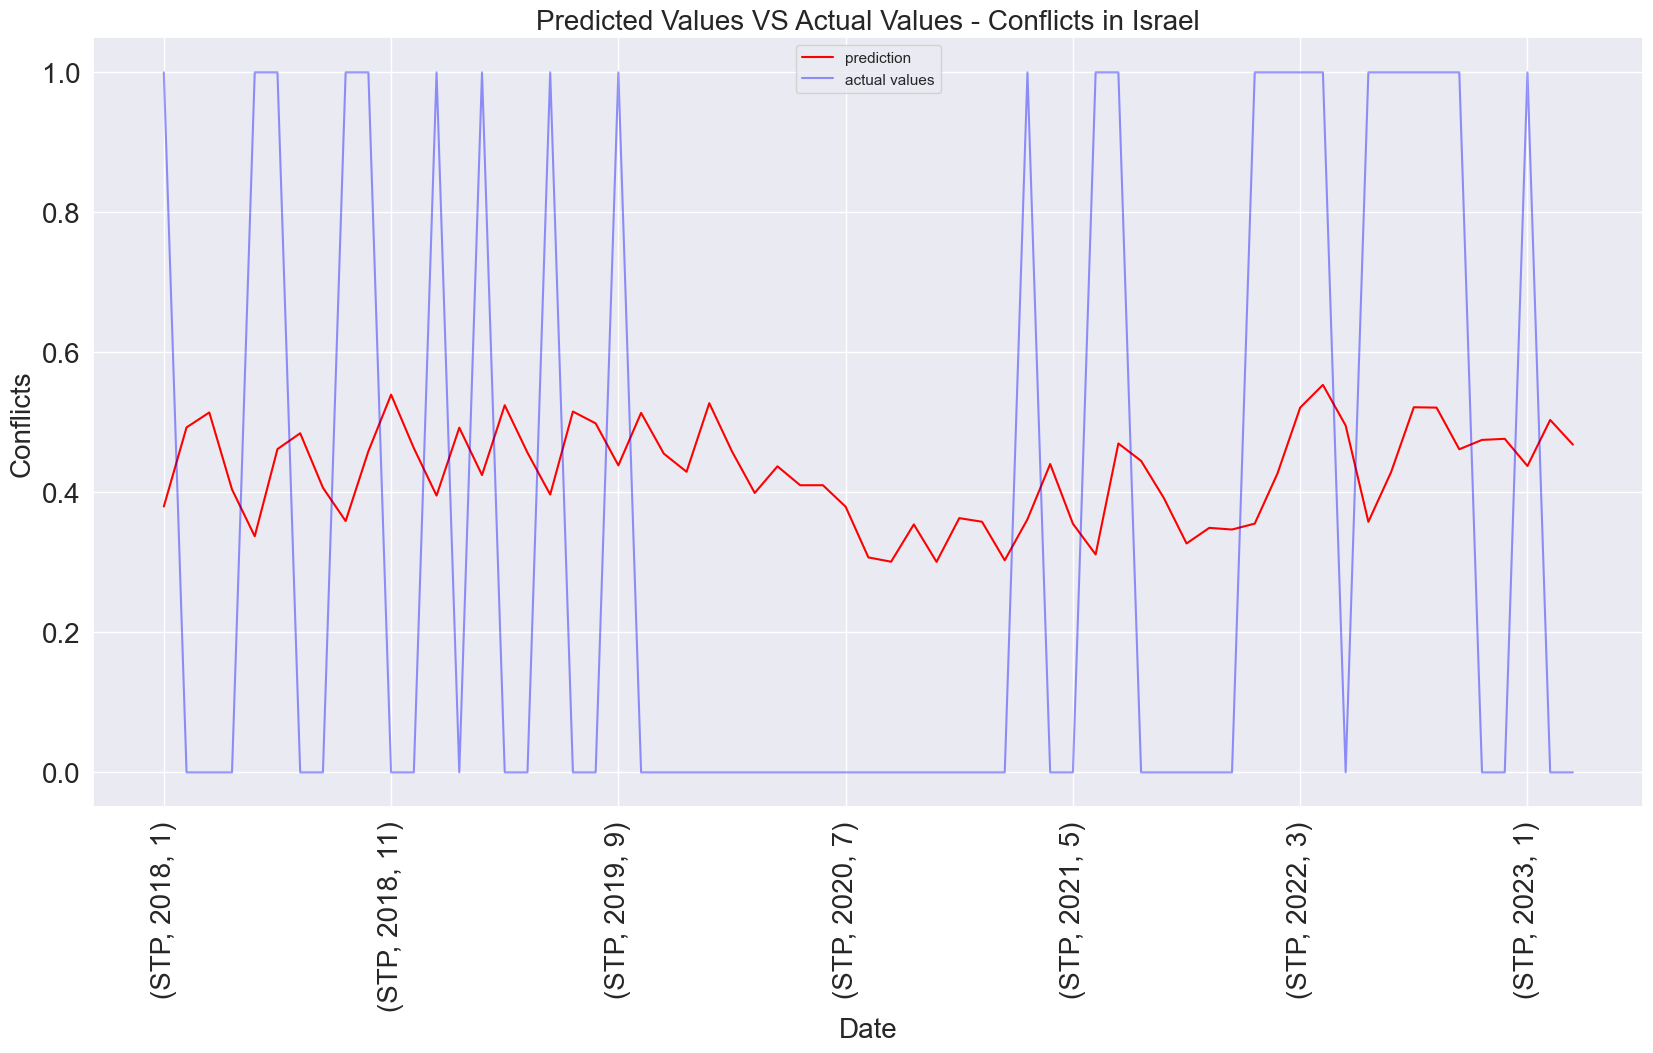

Epoch 1/30


2023-06-29 01:10:47.897498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:48.084598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.1493 - accuracy: 0.5600 - recall_21: 0.0000e+00

2023-06-29 01:10:48.438641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 125ms/step - loss: 0.3357 - accuracy: 0.4673 - recall_21: 0.0111
Epoch 2/30
5/5 [==============================] - 0s 51ms/step - loss: 0.2229 - accuracy: 0.7523 - recall_21: 0.9778
Epoch 3/30
5/5 [==============================] - 0s 37ms/step - loss: 0.1983 - accuracy: 0.4206 - recall_21: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 26ms/step - loss: 0.2041 - accuracy: 0.4206 - recall_21: 1.0000 
Epoch 5/30
5/5 [==============================] - 0s 23ms/step - loss: 0.2084 - accuracy: 0.4206 - recall_21: 1.0000 
Epoch 6/30
5/5 [==============================] - 0s 24ms/step - loss: 0.2013 - accuracy: 0.4206 - recall_21: 1.0000 
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 0.1862 - accuracy: 0.4206 - recall_21: 1.0000   
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.1695 - accuracy: 0.4486 - recall_21: 0.9889
Epoch 9/30
5/5 [==============================] - 0s 12ms/step - los

2023-06-29 01:10:51.609181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:51.658765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Yemen, Rep. - Precision: 0.9523809523809523


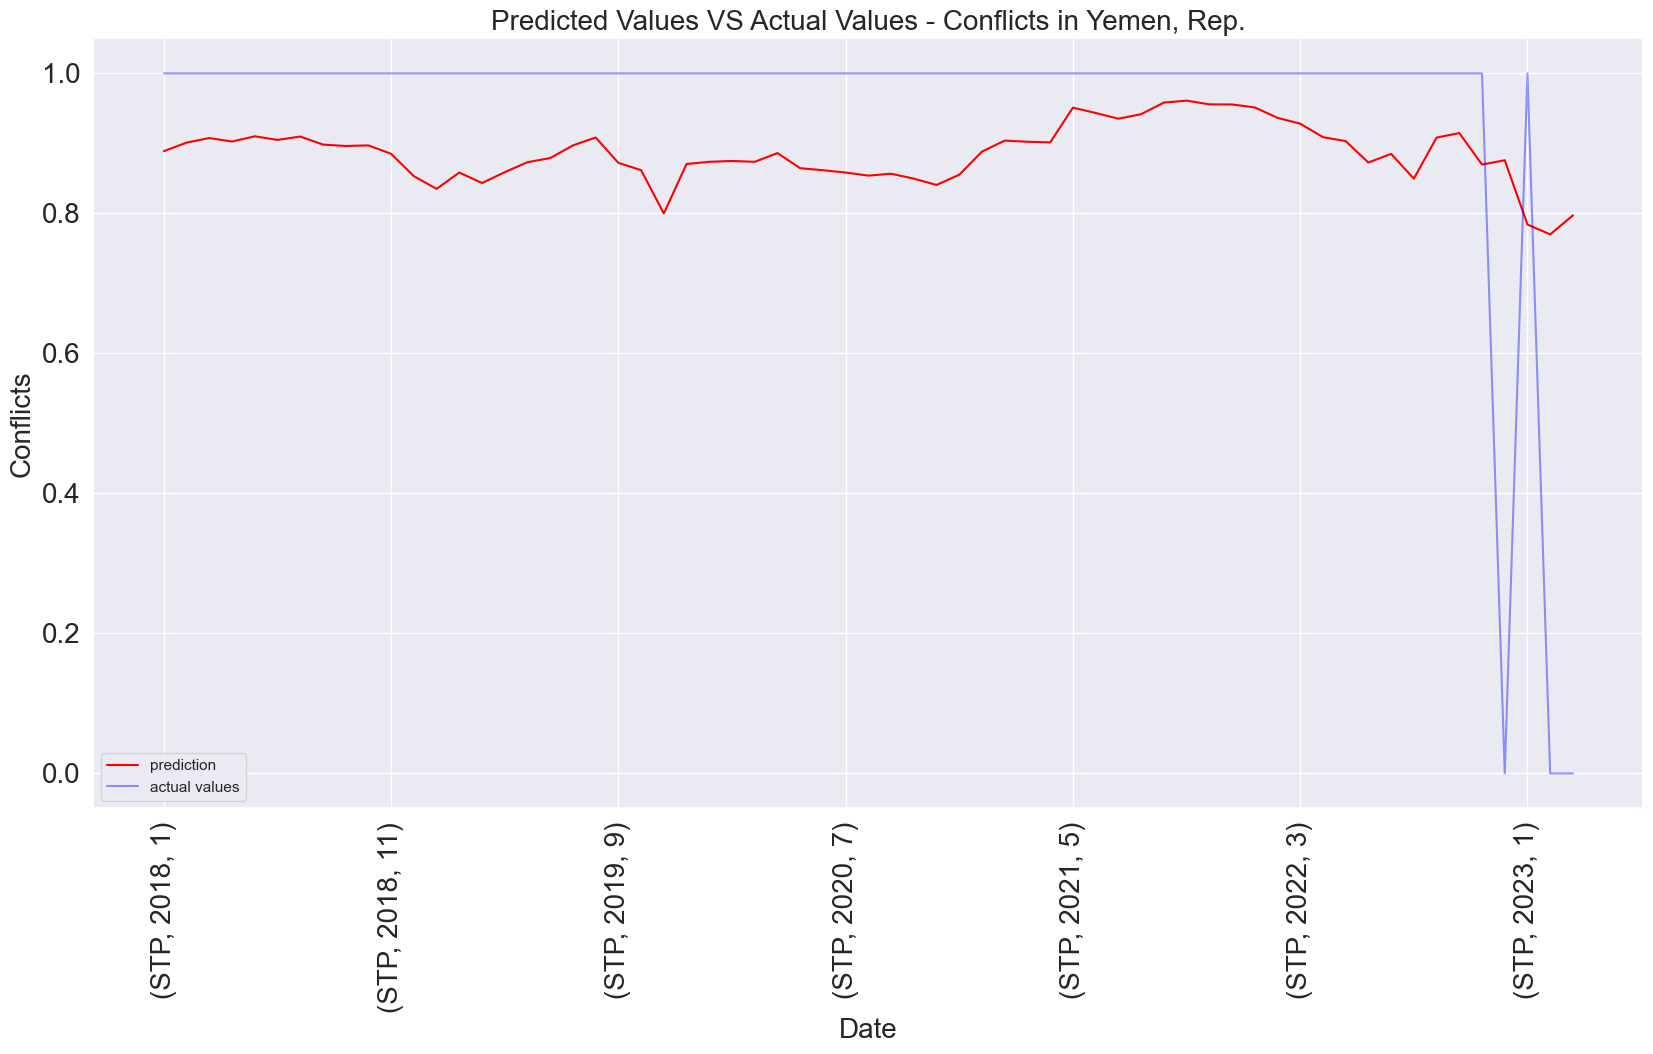

Epoch 1/30


2023-06-29 01:10:52.975518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:53.256983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 7s - loss: 0.1456 - accuracy: 0.4200 - recall_22: 0.0000e+00

2023-06-29 01:10:53.630124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 128ms/step - loss: 0.3062 - accuracy: 0.4673 - recall_22: 0.0122
Epoch 2/30
5/5 [==============================] - 0s 50ms/step - loss: 0.1825 - accuracy: 0.9393 - recall_22: 0.9634
Epoch 3/30
5/5 [==============================] - 0s 28ms/step - loss: 0.1526 - accuracy: 0.4860 - recall_22: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 21ms/step - loss: 0.1493 - accuracy: 0.4112 - recall_22: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 29ms/step - loss: 0.1417 - accuracy: 0.4252 - recall_22: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 22ms/step - loss: 0.1240 - accuracy: 0.5374 - recall_22: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 22ms/step - loss: 0.1022 - accuracy: 0.7850 - recall_22: 0.9878
Epoch 8/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0825 - accuracy: 0.9439 - recall_22: 0.9878
Epoch 9/30
5/5 [==============================] - 0s 22ms/step - loss: 0.0

2023-06-29 01:10:56.832132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:56.881269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Syrian Arab Republic - Precision: 0.9365079365079365


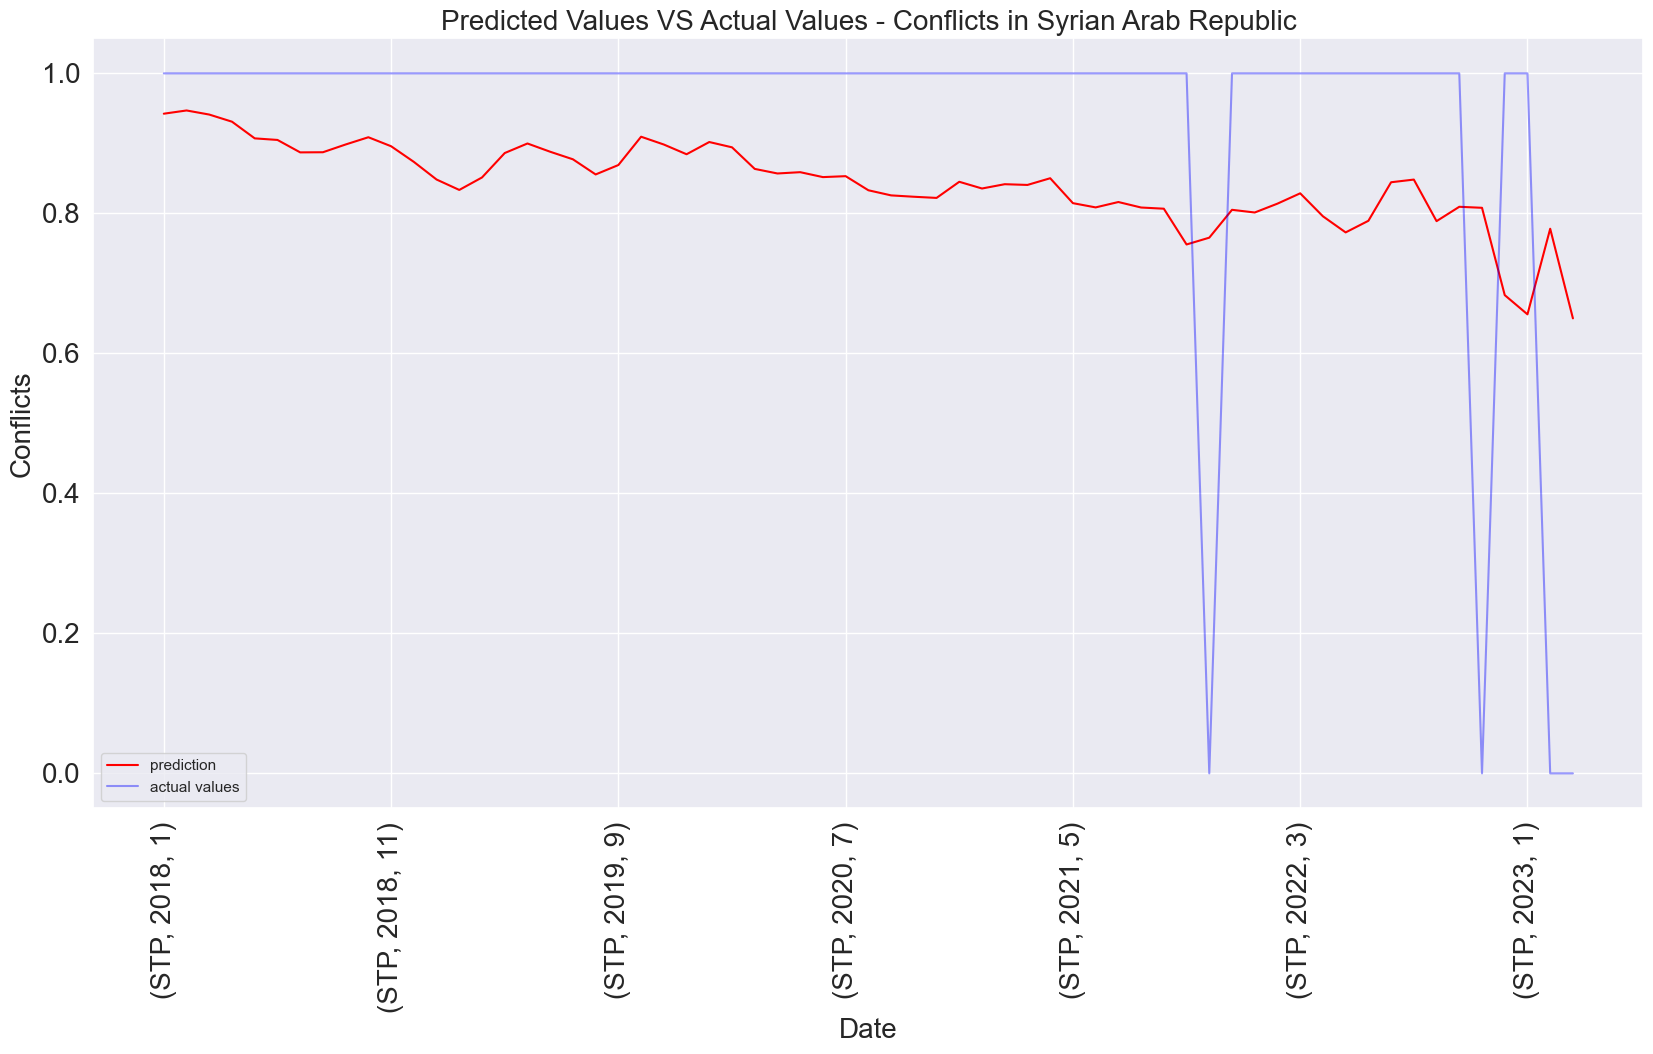

Epoch 1/30


2023-06-29 01:10:57.723496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:10:57.911109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.1518 - accuracy: 0.2800 - recall_23: 0.0000e+00

2023-06-29 01:10:58.286004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 130ms/step - loss: 0.2530 - accuracy: 0.4486 - recall_23: 0.3375
Epoch 2/30
5/5 [==============================] - 0s 67ms/step - loss: 0.2131 - accuracy: 0.4533 - recall_23: 0.9875
Epoch 3/30
5/5 [==============================] - 0s 26ms/step - loss: 0.2127 - accuracy: 0.3785 - recall_23: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 26ms/step - loss: 0.2080 - accuracy: 0.3832 - recall_23: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 21ms/step - loss: 0.1991 - accuracy: 0.4393 - recall_23: 0.9875
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 0.1920 - accuracy: 0.5794 - recall_23: 0.9875
Epoch 7/30
5/5 [==============================] - 0s 22ms/step - loss: 0.1851 - accuracy: 0.6636 - recall_23: 0.9875
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.1780 - accuracy: 0.6776 - recall_23: 0.9875
Epoch 9/30
5/5 [==============================] - 0s 16ms/step - loss: 0.1

2023-06-29 01:11:01.832793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:11:01.883405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Mexico - Precision: 0.9365079365079365


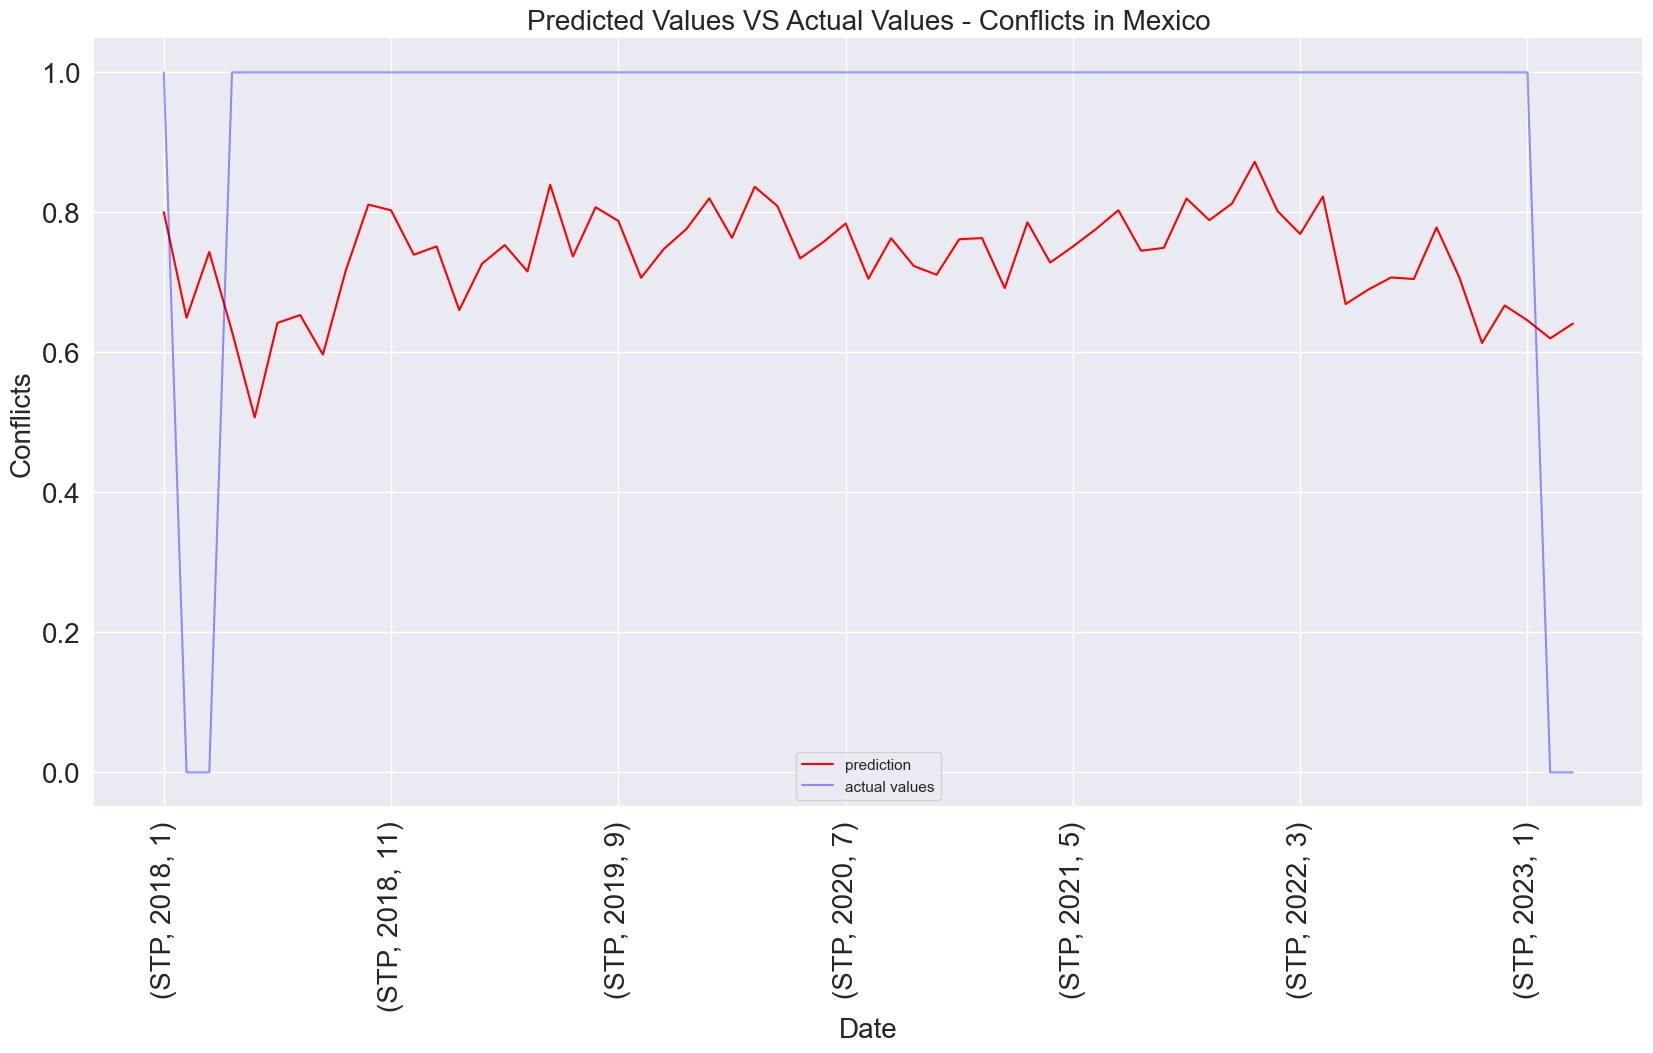

In [116]:
for i in range(len(top_10_country_names)): 
    # Obtain one country's data 
    country = armedconfdf[armedconfdf.country == top_10_country_names[i]]
        
    # Train test split, normalization and reshape the data
    x_train, x_test, y_train, y_test  = normalization_train_test_split(country)
    
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Create dictionary mapping classes to their weights
    class_weight_dict = dict(enumerate(class_weights))

# design network for conflicts 
    model = Sequential()
    model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
    model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

    # fit network with class weights for handling imbalance
    history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weight_dict, verbose=1, shuffle=False)  
    # make a prediction
   # make a prediction
    y_test_pre = model.predict(x_test)

# Trim y_test and X_test to match the length of y_test_pre
    y_test = y_test[:len(y_test_pre)]
    X_test = X_test[:len(y_test_pre)]


# Precision calculation
    precision = precision_score(y_test, [round(i[0]) for i in y_test_pre])
    print('{} - Precision: {}'.format(top_10_country_names[i], precision))

# Create new dataframe for plot 
    pa = pd.DataFrame()

# Adjust the date to match the length of y_test_pre
    # Adjust the date to match the length of y_test_pre
    pa['Date'] = list(X_test.index)[:len(y_test_pre)]
    pa['Prediction'] = [i[0] for i in y_test_pre]
    pa['Actual Values'] = y_test

    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(kind='line', label='prediction', color='red', alpha=1)
    pa.groupby("Date")['Actual Values'].sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Conflicts',fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Actual Values - Conflicts in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()
    plt.show()
